<a href="https://colab.research.google.com/github/kjaron83/tensorflow-tutorials/blob/master/classification/intel_image_classification/02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing the [Intel natural scenes](https://www.kaggle.com/puneet6060/intel-image-classification) dataset.

This time I use feature extraction and try serveral different pre-build architectures.

In [2]:
# Are we using a GPU?
!nvidia-smi

Thu Mar 10 15:21:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Download zip file of images showing natural scenes around the world

# Train data
!wget https://archive.org/download/seg_train/seg_train.zip
# Test data
!wget https://archive.org/download/seg_test/seg_test.zip

--2022-03-10 15:21:10--  https://archive.org/download/seg_train/seg_train.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801409.us.archive.org/24/items/seg_train/seg_train.zip [following]
--2022-03-10 15:21:11--  https://ia801409.us.archive.org/24/items/seg_train/seg_train.zip
Resolving ia801409.us.archive.org (ia801409.us.archive.org)... 207.241.228.149
Connecting to ia801409.us.archive.org (ia801409.us.archive.org)|207.241.228.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209388413 (200M) [application/zip]
Saving to: ‘seg_train.zip’

seg_train.zip       100%[===================>] 199.69M   569KB/s    in 6m 24s  

2022-03-10 15:27:35 (532 KB/s) - ‘seg_train.zip’ saved [209388413/209388413]

--2022-03-10 15:27:35--  https://archive.org/download/seg_test/seg_test.zip
Resolving archive.org (archive.org)...

In [4]:
# Unzip the downloaded files
import zipfile

zip_ref = zipfile.ZipFile("/content/seg_train.zip", "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/seg_test.zip", "r")
zip_ref.extractall()
zip_ref.close()

Skipping data visualization. See: [01.ipynb](https://github.com/kjaron83/tensorflow-tutorials/blob/master/classification/intel_image_classification/01.ipynb)

In [5]:
# Setup the train and test directories
train_dir = "/content/seg_train"
test_dir = "/content/seg_test"

# Make sure we use the same image shape everywhere
TARGET_SIZE = (224, 224)
INPUT_SHAPE = TARGET_SIZE + (3,)

# Batch size for good health
BATCH_SIZE = 32

# Using the same epochs everywhere
EPOCHS = 5

# Same random seed for repeatable results
RANDOM_SEED = 42

In [6]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
# We have 6 classes so this is a categorical classification problem
CLASS_COUNT = len(class_names)
CLASS_MODE = "categorical"

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(RANDOM_SEED)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               target_size=TARGET_SIZE, # convert all images to the same size
                                               class_mode=CLASS_MODE, # type of problem we're working on
                                               seed=RANDOM_SEED)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=TARGET_SIZE,
                                               class_mode=CLASS_MODE,
                                               seed=RANDOM_SEED)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=INPUT_SHAPE) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [11]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [12]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# MobileNetV2 feature vector
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [13]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=len(valid_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220310-153008
Epoch 1/5
439/439 [==============================] - 60s 107ms/step - loss: 0.3028 - accuracy: 0.8898 - val_loss: 0.2217 - val_accuracy: 0.9127
Epoch 2/5
439/439 [==============================] - 46s 106ms/step - loss: 0.1996 - accuracy: 0.9282 - val_loss: 0.2011 - val_accuracy: 0.9237
Epoch 3/5
439/439 [==============================] - 47s 106ms/step - loss: 0.1713 - accuracy: 0.9361 - val_loss: 0.2072 - val_accuracy: 0.9193
Epoch 4/5
439/439 [==============================] - 47s 106ms/step - loss: 0.1551 - accuracy: 0.9418 - val_loss: 0.2092 - val_accuracy: 0.9223
Epoch 5/5
439/439 [==============================] - 47s 106ms/step - loss: 0.1408 - accuracy: 0.9480 - val_loss: 0.2137 - val_accuracy: 0.9180


In [14]:
resnet_model.save("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/resnet50V2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/resnet50V2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/resnet50V2/assets


In [15]:
import tensorflow as tf

# Load in a model and evaluate it
resnet_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/resnet50V2")

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

pred_dir = "/content/seg_test"

pred_datagen = ImageDataGenerator(rescale=1./255)

print("Images for prediction:")
pred_data = pred_datagen.flow_from_directory(pred_dir,
                                             target_size=TARGET_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode=CLASS_MODE,
                                             shuffle=False)
y_true = pred_data.classes

Images for prediction:
Found 3000 images belonging to 6 classes.


In [18]:
#Confution Matrix and Classification Report
from sklearn.metrics import confusion_matrix

Y_pred = resnet_model.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[391,   0,   1,   0,   1,  44],
       [  0, 469,   2,   0,   1,   2],
       [  1,   2, 462,  73,  15,   0],
       [  0,   4,  59, 448,  13,   1],
       [  0,   2,   2,   5, 497,   4],
       [ 13,   0,   0,   1,   0, 487]])

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
  plt.figure(figsize=(10,10))

  cm = confusion_matrix(y_true, y_pred)
  ax = sns.heatmap(cm,cbar=False,annot=True,cmap=plt.cm.Blues,fmt='.4g')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(class_names)
  ax.yaxis.set_ticklabels(class_names);

# Resnet 50 V2 confusion matrix

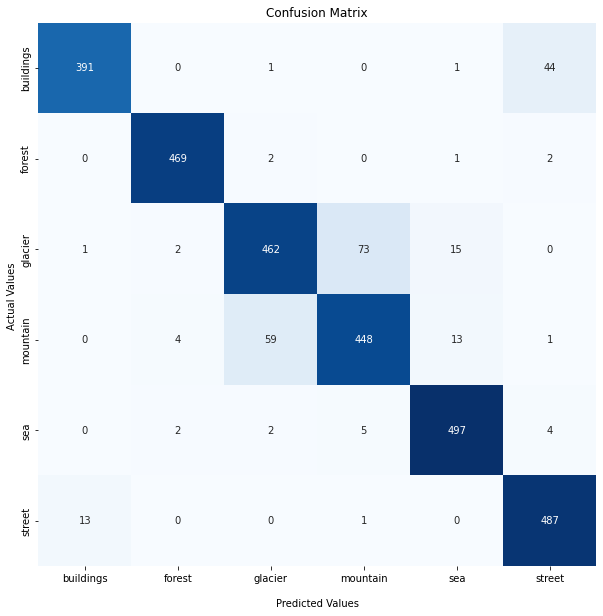

In [20]:
plot_confusion_matrix(y_true, y_pred, class_names)

In [21]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=len(valid_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetB0V1")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0V1/20220310-153631
Epoch 1/5
439/439 [==============================] - 46s 85ms/step - loss: 0.3250 - accuracy: 0.8945 - val_loss: 0.2311 - val_accuracy: 0.9150
Epoch 2/5
439/439 [==============================] - 34s 78ms/step - loss: 0.1949 - accuracy: 0.9330 - val_loss: 0.2067 - val_accuracy: 0.9293
Epoch 3/5
439/439 [==============================] - 34s 78ms/step - loss: 0.1738 - accuracy: 0.9384 - val_loss: 0.1998 - val_accuracy: 0.9267
Epoch 4/5
439/439 [==============================] - 35s 79ms/step - loss: 0.1599 - accuracy: 0.9440 - val_loss: 0.2035 - val_accuracy: 0.9263
Epoch 5/5
439/439 [==============================] - 34s 78ms/step - loss: 0.1505 - accuracy: 0.9468 - val_loss: 0.1875 - val_accuracy: 0.9320


In [22]:
efficientnet_model.save("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/efficientnetB0V1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/efficientnetB0V1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/efficientnetB0V1/assets


In [23]:
import tensorflow as tf

# Load in a model and evaluate it
efficientnet_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/efficientnetB0V1")

efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 4,057,250
Trainable params: 7,686
Non-trainable params: 4,049,564
_________________________________________________________________


# EfficientNetB0 feature vector (version 1) confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

Y_pred = efficientnet_model.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[412,   0,   0,   0,   2,  23],
       [  0, 471,   1,   2,   0,   0],
       [  0,   0, 485,  50,  17,   1],
       [  0,   1,  55, 462,   6,   1],
       [  1,   0,  12,   2, 495,   0],
       [ 28,   0,   0,   2,   0, 471]])

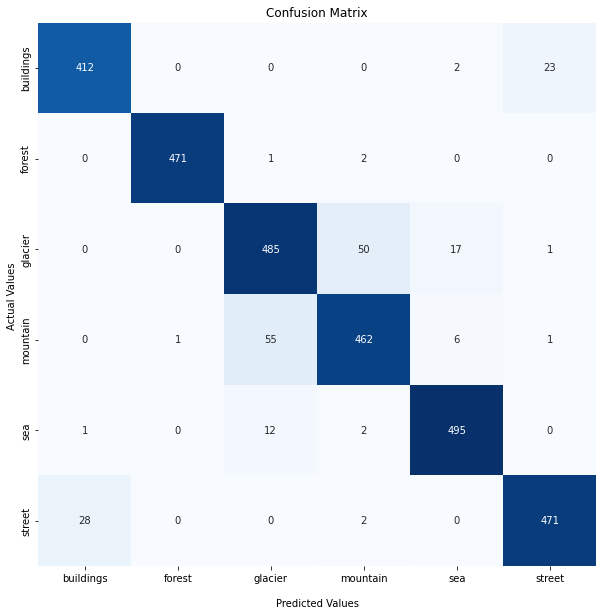

In [25]:
#Confution Matrix and Classification Report
Y_pred = efficientnet_model.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, class_names)

In [26]:
# Create model
mobilenet_model = create_model(mobilenet_url, num_classes=train_data.num_classes)

# Compile
mobilenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
mobilenet_history = mobilenet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=len(valid_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="mobilenetV2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/mobilenetV2/20220310-154744
Epoch 1/5
439/439 [==============================] - 36s 74ms/step - loss: 0.3311 - accuracy: 0.8811 - val_loss: 0.2410 - val_accuracy: 0.9127
Epoch 2/5
439/439 [==============================] - 31s 72ms/step - loss: 0.2238 - accuracy: 0.9203 - val_loss: 0.2511 - val_accuracy: 0.9113
Epoch 3/5
439/439 [==============================] - 31s 71ms/step - loss: 0.1996 - accuracy: 0.9272 - val_loss: 0.2285 - val_accuracy: 0.9143
Epoch 4/5
439/439 [==============================] - 31s 71ms/step - loss: 0.1810 - accuracy: 0.9346 - val_loss: 0.2195 - val_accuracy: 0.9183
Epoch 5/5
439/439 [==============================] - 31s 70ms/step - loss: 0.1695 - accuracy: 0.9373 - val_loss: 0.2235 - val_accuracy: 0.9167


In [27]:
mobilenet_model.save("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/mobilenetV2")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/mobilenetV2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/intel_image_classification/mobilenetV2/assets


In [28]:
import tensorflow as tf

# Load in a model and evaluate it
mobilenet_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/mobilenetV2")

mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


# MobileNetV2 feature vector confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

Y_pred = mobilenet_model.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm

array([[394,   0,   1,   1,   1,  40],
       [  0, 470,   1,   1,   2,   0],
       [  0,   2, 471,  64,  15,   1],
       [  1,   4,  61, 451,   7,   1],
       [  0,   1,  17,   7, 483,   2],
       [ 16,   0,   0,   1,   3, 481]])

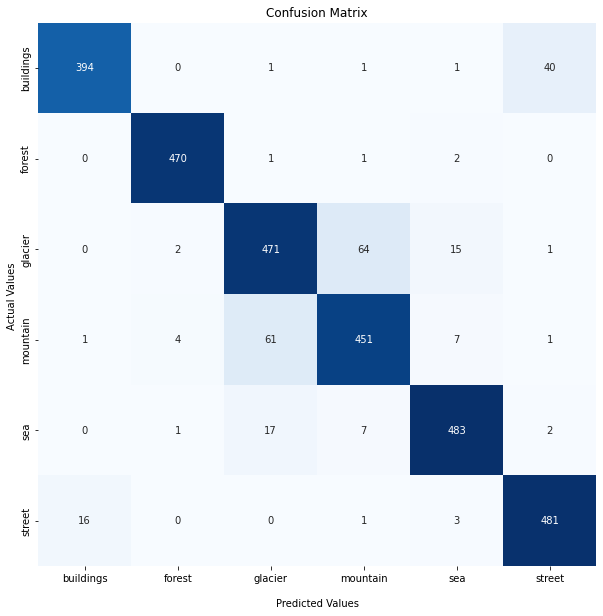

In [30]:
#Confution Matrix and Classification Report
Y_pred = mobilenet_model.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs. MobileNetV2" \
  --description "Comparing three different TF Hub feature extraction models architectures using Intel natural scenes dataset." \
  --one_shot

# TensorBoard
View your TensorBoard at https://tensorboard.dev/experiment/qNyxnS43S8ybsWggONTWng/

In [36]:
!tensorboard dev list

https://tensorboard.dev/experiment/qNyxnS43S8ybsWggONTWng/
	Name                 EfficientNetB0 vs. ResNet50V2 vs. MobileNetV2
	Description          Comparing three different TF Hub feature extraction models architectures using Intel natural scenes dataset.
	Id                   qNyxnS43S8ybsWggONTWng
	Created              2022-03-10 15:52:25 (3 minutes ago)
	Updated              2022-03-10 15:52:28 (3 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7559918
Total: 1 experiment(s)


In [35]:
# !tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]